Marcin Wardyński  
wtorek, 9:45

## Laboratorium 7
### 7.3 RBM - własna implementacja

In [128]:
import importlib
import lab7_utils as utils
importlib.reload(utils)

import numpy as np
import matplotlib.pyplot as plt

In [100]:
import matplotlib.pyplot as plt

def sigmoid(matrix):
    return 1.0 / (1.0 + np.exp(-matrix))

def append_ones(matrix):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def save_tiles(examples, epoch):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = examples[r, c]
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.suptitle(f'Weights at Epoch {epoch}')
    plt.savefig('imgs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()    

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

import time

class RBM:
    def __init__(self, visible_dim, hidden_dim):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim

        self.W = np.random.normal(scale=0.01,
                                  size=(self.visible_dim+1, self.hidden_dim+1)).astype(np.float64)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0

    def fit(self, X, epochs=10, batch_dim=50, lr=0.1):
        for epoch in range(epochs):
            print("Epoch {}:".format(epoch + 1),  end="\t")
            
            start_time = time.time()
            self.train_epoch(X, batch_dim, lr)
            
            elapsed = time.time() - start_time
            error = self.reconstuction_error(X)
            print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))
            self.plot_weights(epoch+1)
    
        print("Training finished!")

    def train_epoch(self, dataset, batch_dim, lr):
        batches_limit = dataset.shape[0] / batch_dim
        for batch_idx, batch in enumerate(chunks(dataset, batch_dim)):
            self.cdk(batch, lr)
            if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

    def cdk(self, minibatch, lr, k=3):
        observations_count = minibatch.shape[0]

        positive_visible = minibatch
        negative_visible = append_ones(zeros(observations_count, self.visible_dim))

        positive_hidden = append_ones(zeros(observations_count, self.hidden_dim))
        negative_hidden = append_ones(zeros(observations_count, self.hidden_dim))

        positive_hidden[:, :-1] = sigmoid(positive_visible @ self.W[:, :-1])
        positive_gradient = np.transpose(positive_visible) @ positive_hidden / observations_count 

        negative_hidden[:, :-1] = positive_hidden[:, :-1] > rand(positive_hidden.shape[0], positive_hidden.shape[1] - 1)
        negative_visible[:, :-1] = sigmoid(negative_hidden @ np.transpose(self.W[:-1, :])) > rand(negative_visible.shape[0], negative_visible.shape[1] - 1)

        for _ in range(k-1):
            negative_hidden[:, :-1] = sigmoid(negative_visible @ self.W[:, :-1]) > rand(negative_hidden.shape[0], negative_hidden.shape[1] - 1)
            negative_visible[:, :-1] = sigmoid(negative_hidden @ np.transpose(self.W[:-1, :])) > rand(negative_visible.shape[0], negative_visible.shape[1] - 1)
        negative_hidden[:, :-1] = sigmoid(negative_visible @ self.W[:, :-1])

        negative_gradient = np.transpose(negative_visible) @ negative_hidden / observations_count

        self.W += lr * positive_gradient - lr * negative_gradient

    def reconstuction_error(self, minibatch):
        observations_count = minibatch.shape[0]
        
        reconstructed = self.reconstruct(minibatch)
        error = np.sum((minibatch[:, :-1] - reconstructed) ** 2) / observations_count

        return error
    
    def reconstruct(self, minibatch):
        observations_count = minibatch.shape[0]
        visible = zeros(observations_count, self.visible_dim)
        hidden = append_ones(zeros(observations_count, self.hidden_dim))

        hidden[:, :-1] = sigmoid(minibatch @ self.W[:, :-1]) > rand(hidden.shape[0], hidden.shape[1] - 1)
        visible = sigmoid(hidden @ np.transpose(self.W[:-1, :]))

        return visible

    def plot_weights(self, step=0):
        weights = np.reshape(np.transpose(self.W)[:-1, :-1], newshape=(8, -1, 28, 28))
        weights = np.clip(weights, -1, 1)
        save_tiles(weights, step)

    


In [129]:
X_train, X_test, y_train, y_test = utils.get_dataset(dataset_name=utils.Dataset_Select.F_MNIST.value, print_sample_number=0)

In [130]:
visible_dim = 28 * 28
hidden_dim = 40

rbm = RBM(visible_dim=visible_dim, hidden_dim=hidden_dim)
dataset = append_ones(X_train)
rbm.fit(dataset)

Epoch 1:	##################################################	elapsed: 1.77s, reconstruction error: 65.54
Epoch 2:	##################################################	elapsed: 1.74s, reconstruction error: 58.21
Epoch 3:	##################################################	elapsed: 1.71s, reconstruction error: 53.81
Epoch 4:	##################################################	elapsed: 1.81s, reconstruction error: 51.28
Epoch 5:	##################################################	elapsed: 1.73s, reconstruction error: 49.76
Epoch 6:	##################################################	elapsed: 1.80s, reconstruction error: 48.78
Epoch 7:	##################################################	elapsed: 1.80s, reconstruction error: 48.07
Epoch 8:	##################################################	elapsed: 1.82s, reconstruction error: 47.58
Epoch 9:	##################################################	elapsed: 1.84s, reconstruction error: 47.28
Epoch 10:	##################################################	ela

In [122]:
import glob
import imageio.v2 as imageio
import tensorflow_docs.vis.embed as embed

def create_and_store_gif(anim_file):
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('imgs/image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)


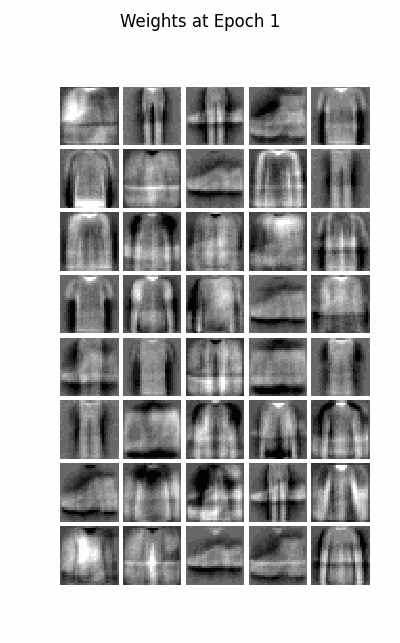

In [123]:
gif_file = 'imgs/weights.gif'
create_and_store_gif(gif_file)
embed.embed_file(gif_file)

In [178]:
def plot_reconstruction(original, reconstructed):
    num_images = min(10, original.shape[0])
    size = original.shape[1]
    plt.figure(figsize=(20, 4))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(int(np.sqrt(size)), -1), cmap='gray')
        plt.title(f"Orig {i}")
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].reshape(int(np.sqrt(size)), -1), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

def compute_ssim(original, reconstructed):
    data_range = 1.0
    num_images = original.shape[0]
    size = original.shape[1]
    ssim_values = []
    for i in range(num_images):
        orig_img = original[i].reshape(int(np.sqrt(size)), -1)
        recon_img = reconstructed[i].reshape(int(np.sqrt(size)), -1)
        ssim_values.append(ssim(im1=orig_img, im2=recon_img, data_range=data_range))
    return np.mean(ssim_values)

In [135]:
sample = dataset[:10]
reconstructed_sample = rbm.reconstruct(sample)

In [150]:
y_test

[9,
 2,
 1,
 1,
 6,
 1,
 4,
 6,
 5,
 7,
 4,
 5,
 7,
 3,
 4,
 1,
 2,
 4,
 8,
 0,
 2,
 5,
 7,
 9,
 1,
 4,
 6,
 0,
 9,
 3,
 8,
 8,
 3,
 3,
 8,
 0,
 7,
 5,
 7,
 9,
 6,
 1,
 3,
 7,
 6,
 7,
 2,
 1,
 2,
 2,
 4,
 4,
 5,
 8,
 2,
 2,
 8,
 4,
 8,
 0,
 7,
 7,
 8,
 5,
 1,
 1,
 2,
 3,
 9,
 8,
 7,
 0,
 2,
 6,
 2,
 3,
 1,
 2,
 8,
 4,
 1,
 8,
 5,
 9,
 5,
 0,
 3,
 2,
 0,
 6,
 5,
 3,
 6,
 7,
 1,
 8,
 0,
 1,
 4,
 2,
 3,
 6,
 7,
 2,
 7,
 8,
 5,
 9,
 9,
 4,
 2,
 5,
 7,
 0,
 5,
 2,
 8,
 6,
 7,
 8,
 0,
 0,
 9,
 9,
 3,
 0,
 8,
 4,
 1,
 5,
 4,
 1,
 9,
 1,
 8,
 6,
 2,
 1,
 2,
 5,
 1,
 0,
 0,
 0,
 1,
 6,
 1,
 6,
 2,
 2,
 4,
 4,
 1,
 4,
 5,
 0,
 4,
 7,
 9,
 3,
 7,
 2,
 3,
 9,
 0,
 9,
 4,
 7,
 4,
 2,
 0,
 5,
 2,
 1,
 2,
 1,
 3,
 0,
 9,
 1,
 0,
 9,
 3,
 6,
 7,
 9,
 9,
 4,
 4,
 7,
 1,
 2,
 1,
 6,
 3,
 2,
 8,
 3,
 6,
 1,
 1,
 0,
 2,
 9,
 2,
 4,
 0,
 7,
 9,
 8,
 4,
 1,
 8,
 4,
 1,
 3,
 1,
 6,
 7,
 2,
 8,
 5,
 2,
 0,
 7,
 7,
 6,
 2,
 7,
 0,
 7,
 8,
 9,
 2,
 9,
 0,
 5,
 1,
 4,
 4,
 5,
 6,
 9,
 2,
 6,
 8,
 6,
 4,
 2,
 2,


In [179]:
all_cats_reps_ids = [27, 2, 16, 13, 6, 8, 4, 9, 18, 0]
print(np.array(y_test)[all_cats_reps_ids])

test_dataset = append_ones(X_test)
all_cats_reps = test_dataset[all_cats_reps_ids]
reconstructed_all_cats_reps = rbm.reconstruct(all_cats_reps)

[0 1 2 3 4 5 6 7 8 9]


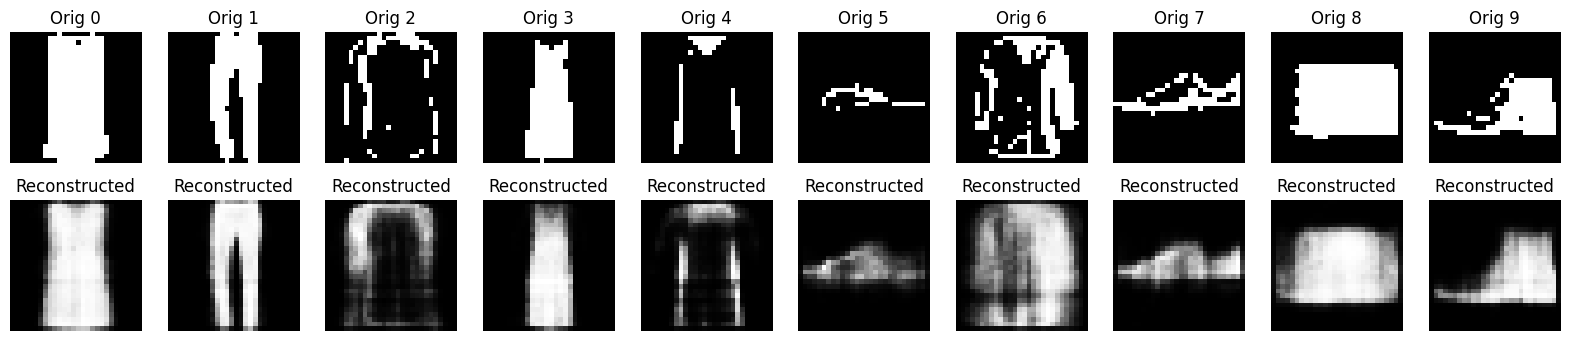

In [180]:
plot_reconstruction(all_cats_reps[:, :-1], reconstructed_all_cats_reps)

In [182]:
compute_ssim(all_cats_reps[:, :-1], reconstructed_all_cats_reps)

np.float64(0.5525095985052595)

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os
import imageio

class RBM_2:
    def __init__(self, visible_dim, hidden_dim):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        # Initialize weights and biases
        self.weights = np.random.normal(0, 0.01, (visible_dim, hidden_dim))
        self.visible_bias = np.zeros(visible_dim)
        self.hidden_bias = np.zeros(hidden_dim)
        self.output_dir = "weights_plots"

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, epochs=10, batch_dim=50, lr=0.1):
        num_samples = X.shape[0]
        
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        for epoch in range(epochs):
            np.random.shuffle(X)  # Shuffle the data
            
            for batch_start in range(0, num_samples, batch_dim):
                batch = X[batch_start:batch_start + batch_dim]

                # Wake phase: Compute probabilities of hidden layer given visible
                hidden_probs = self.sigmoid(np.dot(batch, self.weights) + self.hidden_bias)
                hidden_states = (hidden_probs > np.random.rand(*hidden_probs.shape)).astype(float)

                # Dream phase: Reconstruct visible from hidden
                visible_recon_probs = self.sigmoid(np.dot(hidden_states, self.weights.T) + self.visible_bias)
                visible_recon_states = (visible_recon_probs > np.random.rand(*visible_recon_probs.shape)).astype(float)

                # Recalculate hidden probabilities from reconstructed visible
                hidden_recon_probs = self.sigmoid(np.dot(visible_recon_states, self.weights) + self.hidden_bias)

                # Contrastive Divergence
                positive_gradient = np.dot(batch.T, hidden_probs)
                negative_gradient = np.dot(visible_recon_states.T, hidden_recon_probs)

                self.weights += lr * (positive_gradient - negative_gradient) / batch_dim
                self.visible_bias += lr * np.mean(batch - visible_recon_states, axis=0)
                self.hidden_bias += lr * np.mean(hidden_probs - hidden_recon_probs, axis=0)

            # Save weight visualization for the current epoch
            self.plot_weights(step=epoch + 1, output_dir=self.output_dir)

            # Calculate reconstruction error
            error = np.mean((X - self.sigmoid(np.dot(self.sigmoid(np.dot(X, self.weights) + self.hidden_bias), self.weights.T) + self.visible_bias)) ** 2)
            print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Error: {error:.4f}")

        # Create a GIF from saved plots
        self.create_gif(self.output_dir)

    def reconstruct(self, X):
        hidden_probs = self.sigmoid(np.dot(X, self.weights) + self.hidden_bias)
        reconstructed = self.sigmoid(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return reconstructed

    def plot_weights(self, step=0, output_dir="weights_plots"):
        plt.figure(figsize=(10, 10))
        for i in range(min(100, self.hidden_dim)): #correct to full size
            plt.subplot(10, 10, i + 1)
            plt.imshow(self.weights[:, i].reshape(int(np.sqrt(self.visible_dim)), -1), cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Weight Visualization (Step {step})')
        plt.savefig(f"{output_dir}/weights_epoch_{step:03d}.png")
        plt.close()

    def plot_reconstruction(self, original, reconstructed):
        num_images = min(10, original.shape[0])
        plt.figure(figsize=(20, 4))

        for i in range(num_images):
            # Plot original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(original[i].reshape(int(np.sqrt(self.visible_dim)), -1), cmap='gray')
            plt.title("Original")
            plt.axis('off')

            # Plot reconstructed
            plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(reconstructed[i].reshape(int(np.sqrt(self.visible_dim)), -1), cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')

        plt.suptitle("Original and Reconstructed Images")
        plt.show()

    def compute_ssim(self, original, reconstructed):
        data_range = 1.0
        num_images = original.shape[0]
        ssim_values = []
        for i in range(num_images):
            orig_img = original[i].reshape(int(np.sqrt(self.visible_dim)), -1)
            recon_img = reconstructed[i].reshape(int(np.sqrt(self.visible_dim)), -1)
            ssim_values.append(ssim(im1=orig_img, im2=recon_img, data_range=data_range))
        return np.mean(ssim_values)

    def create_gif(self, output_dir):
        images = []
        for filename in sorted(os.listdir(output_dir)):
            if filename.endswith(".png"):
                file_path = os.path.join(output_dir, filename)
                images.append(imageio.imread(file_path))
        gif_path = os.path.join(output_dir, "weights_visualization.gif")
        imageio.mimsave(gif_path, images, duration=0.5)
        print(f"GIF saved at {gif_path}")


In [69]:
import numpy as np

# Generate synthetic data (e.g., binary images)
visible_dim = 28 * 28  # For example, 28x28 pixel images
hidden_dim = 128


# Initialize and train the RBM
rbm_2 = RBM_2(visible_dim=visible_dim, hidden_dim=hidden_dim)
rbm_2.fit(X_train)

# Reconstruct some data
sample = X_train[:10]
reconstructed_sample = rbm_2.reconstruct(sample)

Epoch 1/10, Reconstruction Error: 0.0603
Epoch 2/10, Reconstruction Error: 0.0497
Epoch 3/10, Reconstruction Error: 0.0453
Epoch 4/10, Reconstruction Error: 0.0430
Epoch 5/10, Reconstruction Error: 0.0415
Epoch 6/10, Reconstruction Error: 0.0403
Epoch 7/10, Reconstruction Error: 0.0396
Epoch 8/10, Reconstruction Error: 0.0391
Epoch 9/10, Reconstruction Error: 0.0386
Epoch 10/10, Reconstruction Error: 0.0382


/var/folders/cd/rgg857vd6xggr1p8_8d98kzr0000gn/T/ipykernel_4296/2754324226.py:111: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF saved at weights_plots/weights_visualization.gif


```
Epoch 1/10, Reconstruction Error: 0.0598
Epoch 2/10, Reconstruction Error: 0.0493
Epoch 3/10, Reconstruction Error: 0.0451
Epoch 4/10, Reconstruction Error: 0.0427
Epoch 5/10, Reconstruction Error: 0.0413
Epoch 6/10, Reconstruction Error: 0.0403
Epoch 7/10, Reconstruction Error: 0.0396
Epoch 8/10, Reconstruction Error: 0.0390
Epoch 9/10, Reconstruction Error: 0.0385
Epoch 10/10, Reconstruction Error: 0.0382
/var/folders/cd/rgg857vd6xggr1p8_8d98kzr0000gn/T/ipykernel_5623/699840368.py:110: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
GIF saved at weights_plots/weights_visualization.gif
```

In [35]:
rbm.create_gif("weights_plots")

/var/folders/cd/rgg857vd6xggr1p8_8d98kzr0000gn/T/ipykernel_5623/699840368.py:110: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF saved at weights_plots/weights_visualization.gif


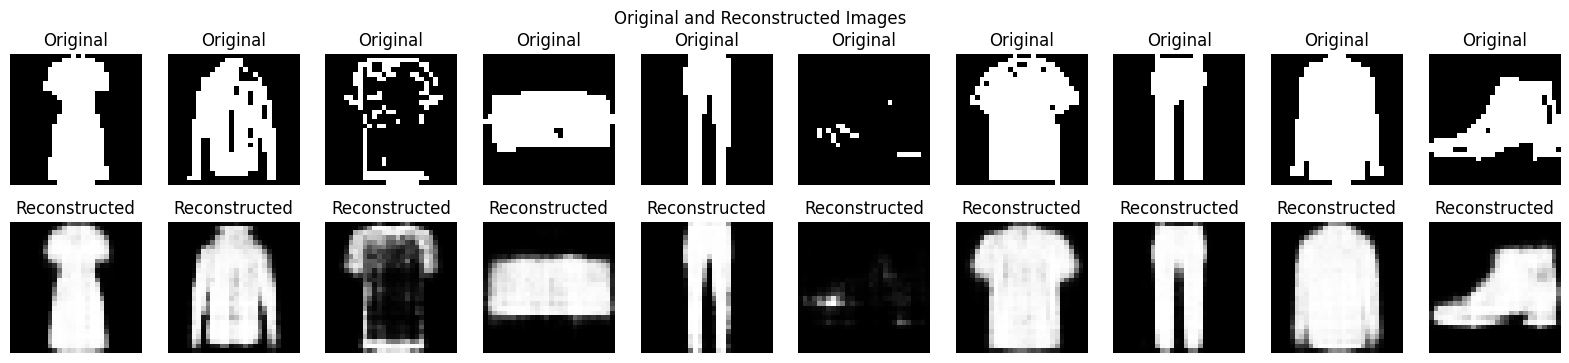

np.float64(0.7123485126769264)

In [71]:

rbm_2.plot_reconstruction(sample, reconstructed_sample)
rbm_2.compute_ssim(sample, reconstructed_sample)